Scraped Data (Sample):
  Tickers                Company      MCap   Price  24h Change % Price Range
0    AAPL             Apple Inc.  385862.0  255.27          0.31     200-500
1    NVDA     NVIDIA Corporation  342052.0  139.67          3.69     100-200
2    MSFT  Microsoft Corporation  323603.0  435.25         -0.31     200-500
3   GOOGL          Alphabet Inc.  238247.0  194.63          1.68     100-200
4    AMZN       Amazon.com, Inc.  236651.0  225.06          0.06     200-500


<ipython-input-1-af0c5d9b949d>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Company', y='MCap', data=top_companies, palette='viridis')


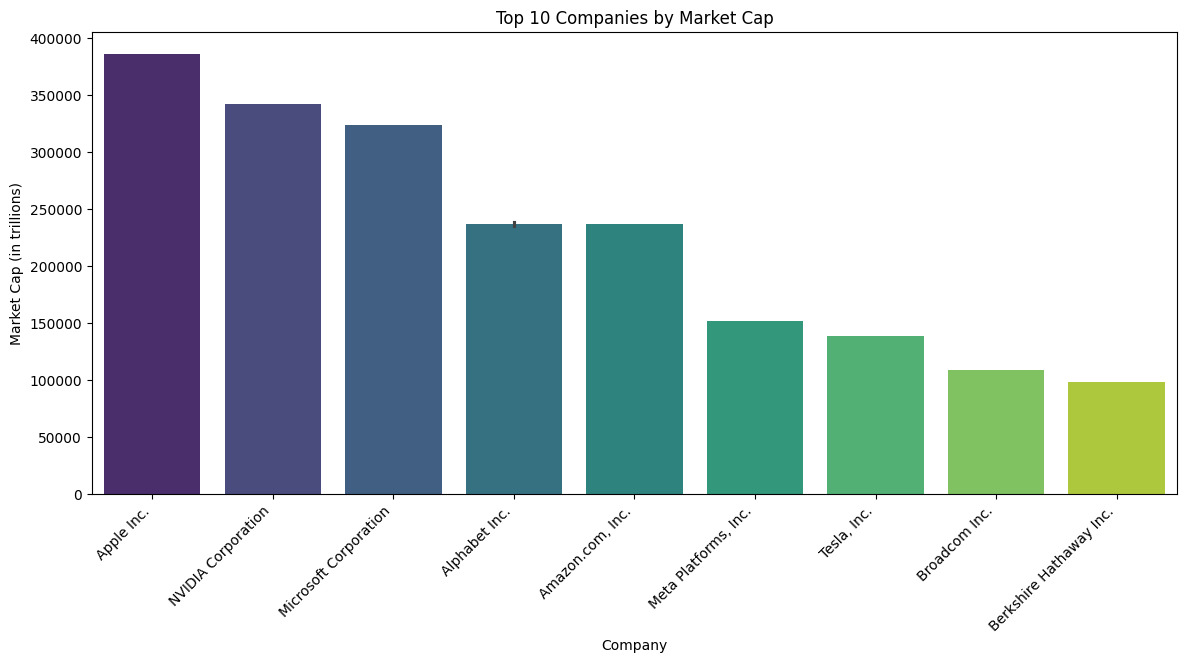

Data saved to S&P500.csv


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URL untuk List S&P500 dari stockanalysis.com
url = "https://stockanalysis.com/list/sp-500-stocks/"

# Fungsi untuk melakukan scraping data
def scrape_sp500_data(url):
    try:
        with requests.Session() as session:
            response = session.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')

        table = soup.select_one('table')
        if not table:
            raise ValueError("Tabel data tidak ditemukan di halaman.")

        headers = [th.text.strip() for th in table.select('thead th')]
        rows = table.select('tbody tr')
        data = [[col.text.strip() for col in row.select('td')] for row in rows]

        df = pd.DataFrame(data, columns=headers)
        df = df.rename(columns={
            'Symbol': 'Tickers',
            'Company Name': 'Company',
            'Market Cap': 'MCap',
            'Stock Price': 'Price',
            '% Change': '24h Change %',
        })

        # Filter kolom penting dan ubah tipe data
        df = df[['Tickers', 'Company', 'MCap', 'Price', '24h Change %']].copy()
        df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
        df['24h Change %'] = pd.to_numeric(df['24h Change %'].str.replace('%', ''), errors='coerce')
        df['MCap'] = df['MCap'].str.replace('[^\d]', '', regex=True).astype(float)

        # Tambahkan kategori untuk rentang harga
        bins = [0, 50, 100, 200, 500, 1000, float('inf')]
        labels = ['<50', '50-100', '100-200', '200-500', '500-1000', '>1000']
        df['Price Range'] = pd.cut(df['Price'], bins=bins, labels=labels)

        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

# Visualisasi data
def visualize_data(df):
    # Bar plot untuk perusahaan top berdasarkan kapitalisasi pasar
    top_companies = df.nlargest(10, 'MCap')
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Company', y='MCap', data=top_companies, palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.title("Top 10 Companies by Market Cap")
    plt.ylabel("Market Cap (in trillions)")
    plt.show()

# Scrape dan visualisasi data
sp500_data = scrape_sp500_data(url)
if sp500_data is not None:
    print("Scraped Data (Sample):")
    print(sp500_data.head())

    # Visualisasi data
    visualize_data(sp500_data)

    # Save ke CSV
    csv_file = "S&P500.csv"
    sp500_data.to_csv(csv_file, index=False)
    print(f"Data saved to {csv_file}")
else:
    print("Gagal mendapatkan data.")
